<a href="https://colab.research.google.com/github/dgazeyreyn/trustpilot-pet-insurance-reviews/blob/main/Positive%20Reviews%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from scipy import stats
from google.colab import files

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [64]:
# Define the base URL of your GitHub repo's raw file links
base_url = 'https://raw.githubusercontent.com/dgazeyreyn/trustpilot-pet-insurance-reviews/refs/heads/main/web_scraping/'

In [60]:
# List of CSV file names (ensure these match your repository structure)
csv_files = ['akc_reviews.csv', 'aspca_reviews.csv', 'embrace_reviews.csv',
             'fetch_reviews.csv', 'figo_reviews.csv', 'healthypaws_reviews.csv',
             'lemonade_reviews.csv', 'petsbest_reviews.csv',
             'pumpkin_reviews.csv', 'spot_reviews.csv']

In [61]:
# Initialize an empty list to store dataframes
dfs = []

In [65]:
# Loop through each CSV file and append the dataframe to the list
for file in csv_files:
    file_url = base_url + file
    df = pd.read_csv(file_url)  # Read each CSV file from GitHub into a dataframe
    dfs.append(df)  # Add the dataframe to the list

In [66]:
# Concatenate all the dataframes into one
combined_df = pd.concat(dfs, ignore_index=True)

In [68]:
# Display the combined dataframe
# combined_df.head()

In [8]:
# Split source column into url and page columns
combined_df[['url', 'page']] = combined_df['source'].str.split('?', expand=True)

In [9]:
# Map url to provider
provider_mapping = {'https://www.trustpilot.com/review/www.akcpetinsurance.com' :'AKC',
                 'https://www.trustpilot.com/review/aspcapetinsurance.com' : 'ASPCA',
                 'https://www.trustpilot.com/review/embracepetinsurance.com' : 'Embrace',
                 'https://www.trustpilot.com/review/fetchpet.com' : 'Fetch',
                 'https://www.trustpilot.com/review/figopetinsurance.com' : 'Figo',
                 'https://www.trustpilot.com/review/www.healthypawspetinsurance.com' : 'Healthy Paws',
                 'https://www.trustpilot.com/review/lemonade.com': 'Lemonade',
                 'https://www.trustpilot.com/review/petsbest.com' : 'Pets Best',
                 'https://www.trustpilot.com/review/www.pumpkin.care': 'Pumpkin',
                 'https://www.trustpilot.com/review/spotpetins.com': 'Spot'}
combined_df['provider'] = combined_df['url'].map(provider_mapping)

In [10]:
# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [11]:
# Ensure the 'provider' column exists
if 'provider' in combined_df.columns:

    # TextBlob Sentiment Analysis: Polarity and Subjectivity
    combined_df['textblob_polarity'] = combined_df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    combined_df['textblob_subjectivity'] = combined_df['text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

    # VADER Sentiment Analysis: Compound score
    combined_df['vader_compound'] = combined_df['text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

    # Assign sentiment categories for TextBlob
    combined_df['textblob_sentiment'] = combined_df['textblob_polarity'].apply(
        lambda score: 'positive' if score > 0 else ('neutral' if score == 0 else 'negative'))

    # Assign sentiment categories for VADER
    combined_df['vader_sentiment'] = combined_df['vader_compound'].apply(
        lambda score: 'positive' if score >= 0.05 else ('neutral' if -0.05 < score < 0.05 else 'negative'))

In [12]:
# Show the first few rows with sentiment categories
print(combined_df[['provider', 'textblob_polarity', 'textblob_sentiment', 'vader_compound', 'vader_sentiment']].head())

  provider  textblob_polarity textblob_sentiment  vader_compound  \
0      AKC           0.461706           positive          0.9889   
1      AKC           0.076190           positive          0.8360   
2      AKC           0.175909           positive          0.9704   
3      AKC           0.547619           positive          0.9678   
4      AKC           0.414286           positive          0.9435   

  vader_sentiment  
0        positive  
1        positive  
2        positive  
3        positive  
4        positive  


In [14]:
# Create a count of text_blob sentiments per provider
text_blob_sentiment_counts = combined_df.groupby(['provider', 'textblob_sentiment']).size().unstack(fill_value=0)

In [15]:
# Normalize to get proportions
text_blob_sentiment_proportions = text_blob_sentiment_counts.div(text_blob_sentiment_counts.sum(axis=1), axis=0)

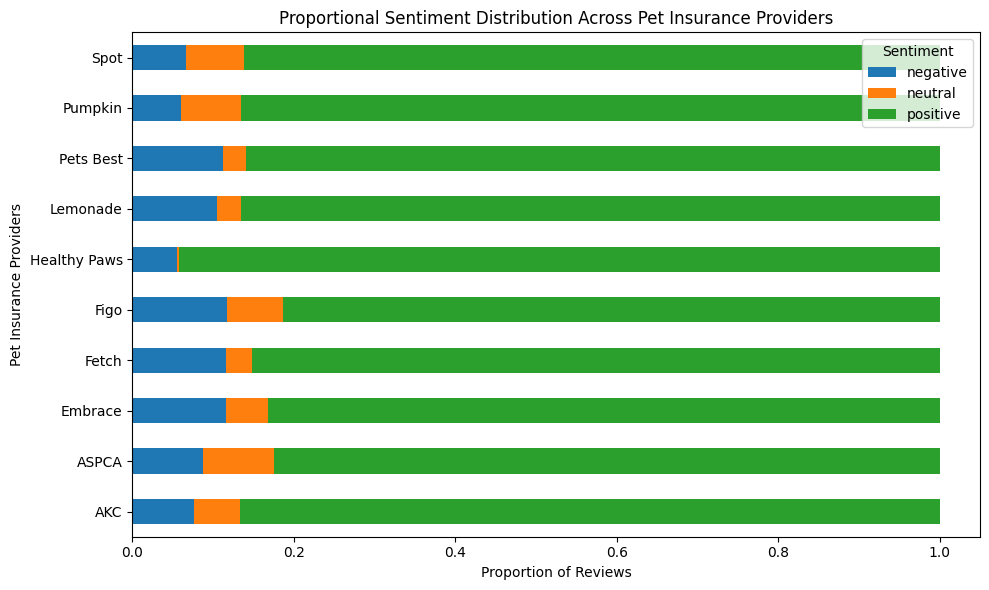

In [16]:
# Plotting
text_blob_sentiment_proportions.plot(kind='barh', stacked=True, figsize=(10, 6))

# Add labels and title
plt.ylabel('Pet Insurance Providers')
plt.xlabel('Proportion of Reviews')
plt.title('Proportional Sentiment Distribution Across Pet Insurance Providers')
plt.legend(title='Sentiment')
plt.tight_layout()

# Show the plot
plt.show()

In [17]:
# Create a count of vader sentiments per provider
vader_sentiment_counts = combined_df.groupby(['provider', 'vader_sentiment']).size().unstack(fill_value=0)

In [18]:
# Normalize to get proportions
vader_sentiment_proportions = vader_sentiment_counts.div(vader_sentiment_counts.sum(axis=1), axis=0)

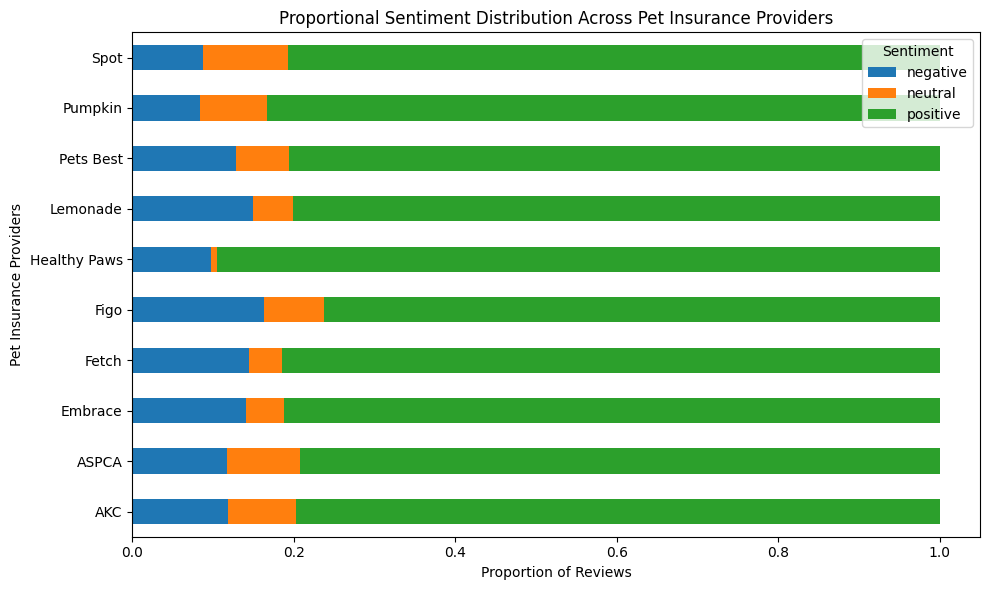

In [19]:
# Plotting
vader_sentiment_proportions.plot(kind='barh', stacked=True, figsize=(10, 6))

# Add labels and title
plt.ylabel('Pet Insurance Providers')
plt.xlabel('Proportion of Reviews')
plt.title('Proportional Sentiment Distribution Across Pet Insurance Providers')
plt.legend(title='Sentiment')
plt.tight_layout()

# Show the plot
plt.show()

In [20]:
# Define expected sentiment based on the rating
def get_expected_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

# Apply the function to create a new 'expected_sentiment' column
combined_df['expected_sentiment'] = combined_df['rating'].apply(get_expected_sentiment)

# Loop through each provider and compute metrics separately
providers = combined_df['provider'].unique()

for provider in providers:
    print(f"Sentiment Classification Report for {provider}:")

    # Filter DataFrame for the current provider
    provider_df = combined_df[combined_df['provider'] == provider]

    # TextBlob Classification Report
    print("TextBlob:")
    print(classification_report(provider_df['expected_sentiment'], provider_df['textblob_sentiment'], target_names=['negative', 'neutral', 'positive']))

    # VADER Classification Report
    print("VADER:")
    print(classification_report(provider_df['expected_sentiment'], provider_df['vader_sentiment'], target_names=['negative', 'neutral', 'positive']))

    print("\n" + "="*50 + "\n")  # Separator between providers

Sentiment Classification Report for AKC:
TextBlob:
              precision    recall  f1-score   support

    negative       0.48      0.44      0.46        71
     neutral       0.19      0.20      0.20        44
    positive       0.92      0.92      0.92       723

    accuracy                           0.84       838
   macro avg       0.53      0.52      0.53       838
weighted avg       0.84      0.84      0.84       838

VADER:
              precision    recall  f1-score   support

    negative       0.46      0.65      0.54        71
     neutral       0.13      0.20      0.16        44
    positive       0.94      0.87      0.90       723

    accuracy                           0.81       838
   macro avg       0.51      0.57      0.53       838
weighted avg       0.86      0.81      0.83       838



Sentiment Classification Report for ASPCA:
TextBlob:
              precision    recall  f1-score   support

    negative       0.52      0.41      0.46       612
     neutral    

In [21]:
# Filter based 'positive' sentiment
positive_df = combined_df[(combined_df['vader_sentiment'] == 'positive') & (combined_df['rating'].isin([4, 5]))]

In [22]:
# Create preprocess_text function
def preprocess_text(text):

    # Tokenize the text
    tokens = word_tokenize(text.lower())

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

In [23]:
# Apply the function to df
positive_df.loc[:, 'text_processed'] = positive_df['text'].apply(preprocess_text).copy()

<ipython-input-23-6488101289e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_df.loc[:, 'text_processed'] = positive_df['text'].apply(preprocess_text).copy()


In [24]:
# Create a list of candidates
customers = positive_df.id.unique()

In [25]:
# sample_reviews = positive_df[positive_df['text_processed'].str.contains("peace mind")]

In [26]:
# Create a list of responses for each candidate using a list comprehension
corpus = [' '.join(positive_df[(positive_df.id==candidate)].text_processed.tolist()) for candidate in customers]

In [27]:
# Instantiate a CountVectorizer object
cv=CountVectorizer(ngram_range=(1, 3))

In [28]:
# Fit transform our text and create a dataframe with the result
X = cv.fit_transform(corpus)
cv.get_feature_names_out()
X = X.toarray()

In [29]:
# Create Bag of Words data frame and set index to customer ids
bow_df = pd.DataFrame(X, columns = cv.get_feature_names_out())
bow_df.index=customers

In [30]:
# Calculate the sum of each column
column_sums = bow_df.sum()

# Create a new DataFrame with column names as rows and their sums
result_df = pd.DataFrame({
    'Column': column_sums.index,
    'Sum': column_sums.values
})

# Filter the DataFrame to include only rows where the sum is greater than 50
filtered_df = result_df[result_df['Sum'] > 50]

In [31]:
# Create manual list of words around broader themes including affordability, ease of use, customer service, and efficiency
positive_list = ['able afford', 'afford', 'affordable', 'always friendly',
                 'always great', 'always helpful', 'always quick', 'amazing',
                 'app easy', 'app easy use', 'appreciate', 'appreciated',
                 'awesome', 'caring', 'choice', 'claim easy', 'claim easy file',
                 'claim easy submit', 'claim fast', 'claim great',
                 'claim handled quickly', 'claim process easy',
                 'claim process quick', 'claim process simple',
                 'claim processed quickly', 'claim promptly', 'claim quick',
                 'claim quick easy', 'claim quickly', 'claim simple',
                 'claim super easy', 'claim timely', 'claim timely manner',
                 'clear', 'compassion', 'compassionate', 'competitive',
                 'convenient', 'cost', 'could afford', 'courteous',
                 'coverage great', 'covered everything',
                 'customer service excellent', 'customer service great',
                 'customer service helpful', 'customer service quick',
                 'definitely recommend', 'ease', 'ease filing',
                 'ease submitting', 'ease submitting claim', 'easier',
                 'easiest', 'easily', 'easy', 'easy app', 'easy claim',
                 'easy claim process', 'easy claim submission', 'easy deal',
                 'easy fast', 'easy file', 'easy file claim', 'easy follow',
                 'easy get', 'easy make', 'easy make claim', 'easy navigate',
                 'easy process', 'easy quick', 'easy reimbursement', 'easy set',
                 'easy sign', 'easy submit', 'easy submit claim',
                 'easy understand', 'easy upload', 'easy use', 'easy use app',
                 'easy work', 'efficient', 'efficiently', 'everything easy',
                 'exceeded', 'excellent', 'excellent coverage',
                 'excellent customer', 'excellent customer service',
                 'excellent service', 'exceptional', 'extremely easy',
                 'extremely happy', 'extremely helpful', 'fair', 'fantastic',
                 'fast', 'fast claim', 'fast easy', 'fast efficient',
                 'fast processing', 'fast reimbursement', 'fast response',
                 'filing claim easy', 'friendly', 'friendly helpful',
                 'friendly knowledgeable', 'give peace', 'give peace mind',
                 'good coverage', 'good customer', 'good customer service',
                 'good experience', 'good insurance', 'good price',
                 'good service', 'grateful', 'great', 'great company',
                 'great coverage', 'great customer', 'great customer service',
                 'great easy', 'great experience', 'great insurance',
                 'great job', 'great pet insurance', 'great price',
                 'great service', 'great work', 'handled quickly', 'happy',
                 'hassle free', 'helped', 'helpful', 'helpful friendly',
                 'highly recommend', 'highly recommend company',
                 'highly recommended', 'honest', 'impressed', 'incredibly easy',
                 'informative', 'insurance easy', 'insurance good',
                 'insurance great', 'kind', 'knowledgeable', 'life saver',
                 'lifesaver', 'like', 'love', 'love insurance', 'loyal',
                 'made easy', 'make easy', 'much better', 'much easier',
                 'never issue', 'never problem', 'nice', 'outstanding',
                 'paid promptly', 'paid quickly', 'paid within', 'patient',
                 'peace', 'peace mind', 'peace mind knowing', 'perfect',
                 'personable', 'pet insurance easy', 'pet insurance great',
                 'phenomenal', 'piece mind', 'pleasant', 'pleasantly',
                 'pleasantly surprised', 'pleased', 'pleased service',
                 'pleasure', 'polite', 'positive', 'positive experience',
                 'price', 'pricing', 'process claim quickly', 'process easy',
                 'process quick', 'process quick easy', 'process simple',
                 'process super easy', 'processed quickly', 'processed timely',
                 'processed within', 'professional', 'prompt', 'prompt payment',
                 'prompt response', 'promptly', 'protected', 'quality',
                 'question answered', 'quick', 'quick claim', 'quick easy',
                 'quick efficient', 'quick payment', 'quick process',
                 'quick reimbursement', 'quick respond', 'quick response',
                 'quick turn', 'quick turn around', 'quick turnaround',
                 'quickly', 'quickly efficiently', 'really care', 'really easy',
                 'reasonable', 'reasonable price', 'reasonably',
                 'reasonably priced', 'recommend', 'recommend company',
                 'recommend insurance', 'recommend pet insurance',
                 'reimbursed quickly', 'reimbursed within',
                 'reimbursement fast', 'reimbursement quick',
                 'reimbursement within', 'reliable', 'relief', 'relieved',
                 'resolved', 'responsive', 'satisfied', 'seamless',
                 'service easy', 'service excellent', 'service fast',
                 'service good', 'service great', 'service helpful',
                 'service prompt', 'service quick', 'simple', 'simple easy',
                 'smooth', 'smoothly', 'speed', 'speedy', 'straight forward',
                 'straightforward', 'submitting claim easy', 'super',
                 'super easy', 'super easy use', 'super fast', 'super helpful',
                 'supportive', 'sweet', 'terrific', 'thankful', 'thorough',
                 'thrilled', 'timely fashion', 'timely manner', 'top notch',
                 'transparent', 'trust', 'understanding', 'user friendly',
                 'website easy', 'website easy use', 'wonderful', 'worth every',
                 'worth every penny', 'would definitely recommend',
                 'would highly', 'would highly recommend', 'would recommend']

In [32]:
# Subset bow_df columns based on list above
bow_subset_df = bow_df[bow_df.columns.intersection(positive_list)].reset_index()

In [33]:
# Merge brand back to data frame
id_provider = combined_df[['id', 'provider']].drop_duplicates()
bow_subset_df = bow_subset_df.merge(id_provider, left_on='index', right_on='id')
bow_subset_df = bow_subset_df.drop(['id'], axis=1)

In [34]:
# Exclude 'index' (first column) and 'provider' (last column) from being binarized
bow_subset_df['index'] = bow_subset_df['index']  # Keep 'index' intact
bow_subset_df['provider'] = bow_subset_df['provider']  # Keep 'provider' intact
bow_subset_df.iloc[:, 1:-1] = bow_subset_df.iloc[:, 1:-1] != 0  # Binarize all columns except 'index' and 'provider'

<ipython-input-34-7ac613f2742e>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        False
1        False
2        False
3        False
4        False
         ...  
19895    False
19896    False
19897    False
19898    False
19899    False
Name: able afford, Length: 19900, dtype: bool' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  bow_subset_df.iloc[:, 1:-1] = bow_subset_df.iloc[:, 1:-1] != 0  # Binarize all columns except 'index' and 'provider'
<ipython-input-34-7ac613f2742e>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0        False
1        False
2        False
3        False
4        False
         ...  
19895    False
19896    False
19897    False
19898    False
19899    False
Name: afford, Length: 19900, dtype: bool' has dtype incompatible with int64, please explicitly cast to a compat

In [35]:
# Melt and join efficiently
df_bow_melt = pd.melt(bow_subset_df.reset_index(), id_vars='index', value_vars=positive_list)
df_bow_brand = df_bow_melt.merge(combined_df[['id', 'provider']].drop_duplicates(), left_on='index', right_on='id').drop('id', axis=1)
df_bow_brand['provider_text'] = df_bow_brand['provider'] + '_' + df_bow_brand['variable']

In [36]:
# Efficient cross-tabulation
cross_tab = pd.crosstab(df_bow_brand['provider_text'], df_bow_brand['value']).reset_index()
cross_tab.columns = ['provider_text', 'observed_false', 'observed_true']
cross_tab[['provider', 'text']] = cross_tab['provider_text'].str.split('_', expand=True)

In [37]:
# Group once for false and true observed totals
obs_col_tot = cross_tab.groupby('text')[['observed_false', 'observed_true']].sum().reset_index()
obs_col_tot.columns = ['text', 'obs_col_tot_false', 'obs_col_tot_true']

In [38]:
# Merge totals at once
cross_tab = cross_tab.merge(obs_col_tot, on='text')

In [39]:
# Precompute row totals and total sum
cross_tab['obs_row_tot'] = cross_tab['observed_false'] + cross_tab['observed_true']
cross_tab['total'] = cross_tab['obs_col_tot_false'] + cross_tab['obs_col_tot_true']

In [40]:
# Calculate expected counts directly
cross_tab['expected_false'] = cross_tab['obs_row_tot'] * cross_tab['obs_col_tot_false'] / cross_tab['total']
cross_tab['expected_true'] = cross_tab['obs_row_tot'] * cross_tab['obs_col_tot_true'] / cross_tab['total']

In [41]:
# Replace 'obs_exp_flag' with a vectorized condition using numpy
cross_tab['obs_exp_flag'] = (cross_tab[['observed_false', 'observed_true', 'expected_false', 'expected_true']] > 5).all(axis=1)

In [42]:
# Filter rows that pass the threshold
obs_exp_pass = cross_tab.loc[cross_tab['obs_exp_flag']].copy()

In [43]:
# Restrict to text where all 10 providers are present
providers = combined_df['provider'].nunique()
provider_cts_by_text = obs_exp_pass.groupby(['text'])['provider'].count().reset_index()
obs_exp_pass = obs_exp_pass.merge(provider_cts_by_text, left_on='text', right_on='text')
obs_exp_pass = obs_exp_pass.loc[obs_exp_pass['provider_y'] == providers].copy()

In [44]:
# Calculate differences and test statistics
obs_exp_pass['diff_false'] = (obs_exp_pass['observed_false'] - obs_exp_pass['expected_false'])**2 / obs_exp_pass['expected_false']
obs_exp_pass['diff_true'] = (obs_exp_pass['observed_true'] - obs_exp_pass['expected_true'])**2 / obs_exp_pass['expected_true']

In [45]:
# Sum test statistics by text
obs_exp_pass['test_stat_row_tot'] = obs_exp_pass['diff_false'] + obs_exp_pass['diff_true']
test_stat = obs_exp_pass.groupby('text')['test_stat_row_tot'].sum().reset_index()

In [46]:
# Merge once with test_stat
obs_exp_pass = obs_exp_pass.merge(test_stat, on='text', suffixes=('', '_total'))

In [47]:
# Degrees of freedom and critical value calculation
dof = providers - 1
critical_value = stats.chi2.ppf(1 - 0.05, df=dof)
obs_exp_pass['critical_value'] = critical_value

In [48]:
# Statistical significance flag
obs_exp_pass['stat_sig'] = obs_exp_pass['test_stat_row_tot_total'] > obs_exp_pass['critical_value']

In [49]:
# Filter rows that are stat sig
stat_sig_pass = obs_exp_pass[obs_exp_pass['stat_sig']].copy()

In [50]:
# Calculate odds and confidence intervals
stat_sig_pass['unexposed_false'] = stat_sig_pass['obs_col_tot_false'] - stat_sig_pass['observed_false']
stat_sig_pass['unexposed_true'] = stat_sig_pass['obs_col_tot_true'] - stat_sig_pass['observed_true']
stat_sig_pass['exposed_odds'] = stat_sig_pass['observed_true'] / stat_sig_pass['observed_false']
stat_sig_pass['unexposed_odds'] = stat_sig_pass['unexposed_true'] / stat_sig_pass['unexposed_false']
stat_sig_pass['odds_ratio'] = stat_sig_pass['exposed_odds'] / stat_sig_pass['unexposed_odds']

In [51]:
# Confidence interval calculation
se = (1/stat_sig_pass['observed_false'] + 1/stat_sig_pass['observed_true'] + 1/stat_sig_pass['unexposed_false'] + 1/stat_sig_pass['unexposed_true'])**0.5
stat_sig_pass['lower_95_pct_ci'] = np.exp(np.log(stat_sig_pass['odds_ratio']) - 1.96 * se)
stat_sig_pass['upper_95_pct_ci'] = np.exp(np.log(stat_sig_pass['odds_ratio']) + 1.96 * se)

In [52]:
text_to_cat = {'affordable': 'Affordability',
               'amazing': 'Satisfaction',
               'appreciate': 'Satisfaction',
               'caring': 'Service & Support',
               'choice': 'Choice',
               'claim easy': 'Ease',
               'claim quickly': 'Efficiency',
               'clear': 'Service & Support',
               'cost': 'Affordability',
               'courteous': 'Service & Support',
               'ease': 'Ease',
               'easier': 'Ease',
               'easy': 'Ease',
               'easy file': 'Ease',
               'easy file claim': 'Ease',
               'easy submit': 'Ease',
               'easy submit claim': 'Ease',
               'easy understand': 'Ease',
               'easy use': 'Ease',
               'easy work': 'Ease',
               'efficient': 'Efficiency',
               'excellent': 'Satisfaction',
               'excellent service': 'Service & Support',
               'fair': 'Service & Support',
               'fast': 'Efficiency',
               'fast easy': 'Efficiency',
               'friendly': 'Service & Support',
               'grateful': 'Satisfaction',
               'great': 'Satisfaction',
               'great company': 'Satisfaction',
               'great customer service': 'Service & Support',
               'happy': 'Satisfaction',
               'helped': 'Service & Support',
               'helpful': 'Service & Support',
               'highly recommend': 'Recommend',
               'impressed': 'Satisfaction',
               'kind': 'Service & Support',
               'knowledgeable': 'Service & Support',
               'like': 'Satisfaction',
               'love': 'Satisfaction',
               'nice': 'Service & Support',
               'peace': 'Satisfaction',
               'peace mind': 'Satisfaction',
               'pleasant': 'Service & Support',
               'pleased': 'Satisfaction',
               'price': 'Affordability',
               'process easy': 'Ease',
               'professional': 'Service & Support',
               'prompt': 'Efficiency',
               'promptly': 'Efficiency',
               'quick': 'Efficiency',
               'quickly': 'Efficiency',
               'reasonable': 'Satisfaction',
               'recommend': 'Recommend',
               'responsive': 'Service & Support',
               'satisfied': 'Satisfaction',
               'simple': 'Ease',
               'super': 'Satisfaction',
               'thankful': 'Satisfaction',
               'understanding': 'Service & Support',
               'wonderful': 'Satisfaction'}
stat_sig_pass['category'] = stat_sig_pass['text'].map(text_to_cat)

In [53]:
# Creating a new column with the condition
stat_sig_pass['is_between'] = (stat_sig_pass['odds_ratio'] > stat_sig_pass['lower_95_pct_ci']) & (stat_sig_pass['odds_ratio'] < stat_sig_pass['upper_95_pct_ci'])

# This will create a new column 'is_between' with True or False based on the condition

In [54]:
# Define the categories and an empty dictionary to store the pivoted DataFrames
categories = ['Affordability', 'Choice', 'Ease', 'Efficiency', 'Recommend', 'Satisfaction', 'Service & Support']
pivoted_dfs = {}

# Loop through each category, filter, and pivot in one step
for category in categories:
    # Filter the DataFrame based on the current category
    filtered_df = stat_sig_pass[stat_sig_pass['category'] == category]

    # Pivot and store the result in the dictionary
    pivoted_dfs[category] = filtered_df.pivot(index='text', columns='provider_x', values='odds_ratio')

# Access the pivoted DataFrames as needed, e.g., pivoted_dfs['Ease']

In [56]:
# # Write the DataFrame to a CSV file
# obs_exp_pass.to_csv('obs_exp_pass.csv', index=False)
# files.download('obs_exp_pass.csv')